# Gravitational Wave Parameter-Estimation Workshop

## Tutorial: Parameter estimation for a GW150914-like injection in simulated data

(Note, this tutorial and the open-data tutorial (tutorial A) are based on the [GWOSC ODW #3 tutorial 2.4](https://github.com/gw-odw/odw-2020). You may wish to browse that repository for similar notebooks covering a range of gravitational-wave data analysis subjects). 

This example estimates the non-spinning parameters of an injected binary black hole system using
commonly used prior distributions. This will take about 40 minutes to run.
   
More examples at https://lscsoft.docs.ligo.org/bilby/examples.html

##  Installation  (execute only if running on a cloud platform!)

In [ ]:
# -- Use the following line in Google Colab
#! pip install -q 'lalsuite' 'bilby' 'gwpy' 'nestle'

**Important:** With Google Colab, you may need to restart the runtime after running the cell above.

## Initialization

We begin by importing some commonly used functions

In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt

import bilby
from bilby.core.prior import Uniform
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters
%matplotlib inline

## Bilby version

In [2]:
print(bilby.__version__)

1.1.5: (CLEAN) 88cf7e2 2022-01-24 22:26:41 +0000


## Creating fake data
In this notebook, we'll analyse GW150914-like injection. Our first task is to create some data!

Set up a random seed for result reproducibility.  This is optional!

In [3]:
np.random.seed(1234)

We now need to specify the parameters of our injection. You can set this up as a python dictionary

In [4]:
injection_parameters = dict(
    mass_1=36., mass_2=29., a_1=0.4, a_2=0.3, tilt_1=0.5, tilt_2=1.0,
    phi_12=1.7, phi_jl=0.3, luminosity_distance=4000., theta_jn=0.4, psi=2.659,
    phase=1.3, geocent_time=1126259642.413, ra=1.375, dec=-1.2108)

We also need to set up some additional arguments such as what waveform approximant to use and what the minimum frequencies for analysis are. This can again be set up as a python dictionary. While the duration and sampling frequenciy can be set up as variables.

In [5]:
waveform_arguments = dict(waveform_approximant='IMRPhenomPv2',
                          reference_frequency=50., minimum_frequency=20., catch_waveform_errors=True)
duration = 4.
sampling_frequency = 2048.

We will now set up a bilby waveform generator. This wraps up some of the jobs of converting between parameters etc

In [6]:
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments)

21:42 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


We now set up the bilby interferometers and inject data

In [7]:
ifos = bilby.gw.detector.InterferometerList(['H1', 'L1'])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=injection_parameters['geocent_time'] - 3)
injection = ifos.inject_signal(
    waveform_generator=waveform_generator,
    parameters=injection_parameters)

21:43 bilby INFO    : Injected signal in H1:
21:43 bilby INFO    :   optimal SNR = 5.89
21:43 bilby INFO    :   matched filter SNR = 6.42-0.21j
21:43 bilby INFO    :   mass_1 = 36.0
21:43 bilby INFO    :   mass_2 = 29.0
21:43 bilby INFO    :   a_1 = 0.4
21:43 bilby INFO    :   a_2 = 0.3
21:43 bilby INFO    :   tilt_1 = 0.5
21:43 bilby INFO    :   tilt_2 = 1.0
21:43 bilby INFO    :   phi_12 = 1.7
21:43 bilby INFO    :   phi_jl = 0.3
21:43 bilby INFO    :   luminosity_distance = 4000.0
21:43 bilby INFO    :   theta_jn = 0.4
21:43 bilby INFO    :   psi = 2.659
21:43 bilby INFO    :   phase = 1.3
21:43 bilby INFO    :   geocent_time = 1126259642.413
21:43 bilby INFO    :   ra = 1.375
21:43 bilby INFO    :   dec = -1.2108
21:43 bilby INFO    : Injected signal in L1:
21:43 bilby INFO    :   optimal SNR = 4.76
21:43 bilby INFO    :   matched filter SNR = 5.20+0.72j
21:43 bilby INFO    :   mass_1 = 36.0
21:43 bilby INFO    :   mass_2 = 29.0
21:43 bilby INFO    :   a_1 = 0.4
21:43 bilby INFO   

### Looking at the data
Okay, we have spent a bit of time now initializing things. Let's check that everything makes sense. To do this, we'll plot our analysis data alongwise the amplitude spectral density (ASD); this is just the square root of the PSD and has the right units to be comparable to the frequency-domain strain data. We also add the "injection", here we plot the absolute value of the (complex) plus polarization.

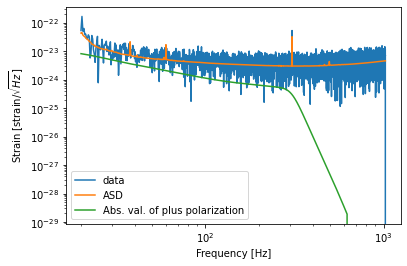

In [8]:
H1 = ifos[0]
H1_injection = injection[0]

fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask  # This is a boolean mask of the frequencies which we'll use in the analysis
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]),
          label="data")
ax.loglog(H1.frequency_array[idxs],
          H1.amplitude_spectral_density_array[idxs],
          label="ASD")
ax.loglog(H1.frequency_array[idxs],
          np.abs(H1_injection["plus"][idxs]),
          label="Abs. val. of plus polarization")
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
ax.legend()
plt.show()

## Low dimensional analysis

As in the open-data tutorial, we'll do a low-dimensional analysis.

### Create a prior

Here, we create a prior fixing everything except the chirp mass, mass ratio and geocent_time parameters to fixed values. The first two we described above. The geocent_time is the time at which it merges.

In [9]:
prior = bilby.core.prior.PriorDict()
prior['chirp_mass'] = Uniform(name='chirp_mass', minimum=27.0,maximum=32.5)
prior['mass_ratio'] = Uniform(name='mass_ratio', minimum=0.5, maximum=1)
# We fix the rest of the parameters to their injected values
for key in ['a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'psi', 'ra',
            'dec','luminosity_distance', 'theta_jn', 'phase', 'geocent_time']:
    prior[key] = injection_parameters[key]

In [10]:
prior

{'chirp_mass': Uniform(minimum=27.0, maximum=32.5, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None),
 'mass_ratio': Uniform(minimum=0.5, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None),
 'a_1': 0.4,
 'a_2': 0.3,
 'tilt_1': 0.5,
 'tilt_2': 1.0,
 'phi_12': 1.7,
 'phi_jl': 0.3,
 'psi': 2.659,
 'ra': 1.375,
 'dec': -1.2108,
 'luminosity_distance': 4000.0,
 'theta_jn': 0.4,
 'phase': 1.3,
 'geocent_time': 1126259642.413}

## Create a likelihood

For Bayesian inference, we need to evaluate the likelihood. In Bilby, we create a likelihood object. This is the communication interface between the sampling part of Bilby and the data. Explicitly, when Bilby is sampling it only uses the `parameters` and `log_likelihood()` of the likelihood object. This means the likelihood can be arbitrarily complicated and the sampling part of Bilby won't mind a bit!

Let's create a `GravitationalWaveTransient`, a special inbuilt method carefully designed to wrap up evaluating the likelihood of a waveform model in some data.

In [11]:
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=waveform_generator, priors=prior,
    time_marginalization=False, phase_marginalization=False, distance_marginalization=False)


This will print a warning about the `start_time`, it is safe to ignore this.

Here, we do not use any marginalization (we fixed these parameters to the injection values in the prior)

### Run the analysis

Now that the prior is set-up and the likelihood is set-up (with the data and the signal mode), we can run the sampler to get the posterior result. This function takes the likelihood and prior along with some options for how to do the sampling and how to save the data.

In [12]:
result_short = bilby.run_sampler(
    likelihood, prior, sampler='dynesty', outdir='short', label="GW150914",
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
    nlive=500, dlogz=3,  # <- Arguments are used to make things fast - not recommended for general use
    clean=True
)

21:45 bilby INFO    : Running for label 'GW150914', output will be saved to 'short'
21:45 bilby INFO    : Using lal version 7.1.7
21:45 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.1.7;Id: c0930b69d9f2ad7151d1cadea5df72633ec47e67;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
21:45 bilby INFO    : Using lalsimulation version 3.1.2
21:45 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v3.1.2;Id: 8c3a6977aa553c9a2019ec287a61dc5ee92087b4;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
21:45 bilby INFO    : Search parameters:
21:45 bilby INFO    :   chirp_mass = Uniform(minimum=27.0, maximum=32.5, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
21:45 bilby INFO    :   mass_ratio = Uniform(minimum=0.5, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None)
21:45 bilby INFO    :   a_1 = 0.4
21:4

0it [00:00, ?it/s]

21:45 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 500, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fed0fab48b0>>, 'dlogz': 3, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5, 'print_method': 'tqdm'}
21:45 bilby INFO    : Checkpoint every check_point_delta_t = 600s
21:45 bilby INFO    : Using dynesty version 1.0.1
21:45 bilby INFO    : Using the bilby

21:49 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/2453 [00:00<?, ?it/s]

21:49 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/2453 [00:00<?, ?it/s]

21:49 bilby INFO    : Summary of results:
nsamples: 2453
ln_noise_evidence: -7999.989
ln_evidence: -7970.681 +/-  0.118
ln_bayes_factor: 29.308 +/-  0.118



### Looking at the outputs

The `run_sampler` returned `result_short` - this is a Bilby result object. The posterior samples are stored in a [pandas data frame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) (think of this like a spreadsheet), let's take a look at it

In [13]:
result_short.posterior

,chirp_mass,mass_ratio,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl,psi,ra,...,chi_2_in_plane,chi_p,cos_tilt_1,cos_tilt_2,redshift,comoving_distance,mass_1_source,mass_2_source,chirp_mass_source,total_mass_source
0,27.794294,0.903369,0.4,0.3,0.5,1.0,1.7,0.3,2.659,1.375,...,0.252441,0.224764,0.877583,0.540302,0.649279,2425.302535,20.372628,18.404002,16.852393,38.776630
1,27.364025,0.916655,0.4,0.3,0.5,1.0,1.7,0.3,2.659,1.375,...,0.252441,0.228544,0.877583,0.540302,0.649279,2425.302535,19.909992,18.250599,16.591510,38.160591
2,27.666407,0.799814,0.4,0.3,0.5,1.0,1.7,0.3,2.659,1.375,...,0.252441,0.195590,0.877583,0.540302,0.649279,2425.302535,21.573019,17.254394,16.774852,38.827413
3,28.961522,0.743400,0.4,0.3,0.5,1.0,1.7,0.3,2.659,1.375,...,0.252441,0.191770,0.877583,0.540302,0.649279,2425.302535,23.446245,17.429929,17.560113,40.876174
4,28.226210,0.855623,0.4,0.3,0.5,1.0,1.7,0.3,2.659,1.375,...,0.252441,0.211246,0.877583,0.540302,0.649279,2425.302535,21.266055,18.195730,17.114275,39.461785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2448,28.145692,0.805075,0.4,0.3,0.5,1.0,1.7,0.3,2.659,1.375,...,0.252441,0.197059,0.877583,0.540302,0.649279,2425.302535,21.873343,17.609677,17.065455,39.483021
2449,28.145692,0.805075,0.4,0.3,0.5,1.0,1.7,0.3,2.659,1.375,...,0.252441,0.197059,0.877583,0.540302,0.649279,2425.302535,21.873343,17.609677,17.065455,39.483021
2450,28.145692,0.805075,0.4,0.3,0.5,1.0,1.7,0.3,2.659,1.375,...,0.252441,0.197059,0.877583,0.540302,0.649279,2425.302535,21.873343,17.609677,17.065455,39.483021
2451,28.145692,0.805075,0.4,0.3,0.5,1.0,1.7,0.3,2.659,1.375,...,0.252441,0.197059,0.877583,0.540302,0.649279,2425.302535,21.873343,17.609677,17.065455,39.483021


We can pull out specific parameters that we are interested in

In [14]:
result_short.posterior["chirp_mass"]

0       27.794294
1       27.364025
2       27.666407
3       28.961522
4       28.226210
          ...    
2448    28.145692
2449    28.145692
2450    28.145692
2451    28.145692
2452    28.145692
Name: chirp_mass, Length: 2453, dtype: float64

This returned another `pandas` object. If you just want to get the numbers as a numpy array run

In [15]:
Mc = result_short.posterior["chirp_mass"].values

We can then get some useful quantities such as the 90\% credible interval

In [16]:
lower_bound = np.quantile(Mc, 0.05)
upper_bound = np.quantile(Mc, 0.95)
median = np.quantile(Mc, 0.5)
print("Mc = {} with a 90% C.I = {} -> {}".format(median, lower_bound, upper_bound))

Mc = 28.148614512241277 with a 90% C.I = 27.760531557804406 -> 28.536531287165506


We can then plot the chirp mass in a histogram adding a region to indicate the 90\% C.I.

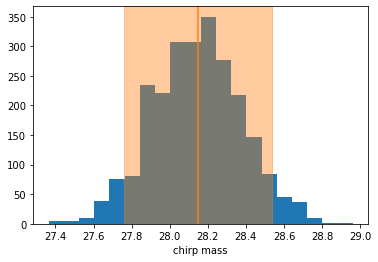

In [17]:
fig, ax = plt.subplots()
ax.hist(result_short.posterior["chirp_mass"], bins=20)
ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.4)
ax.axvline(median, color='C1')
ax.set_xlabel("chirp mass")
plt.show()

The result object also has in-built methods to make nice plots such as corner plots. You can add the priors if you are only plotting parameter which you sampled in, e.g.

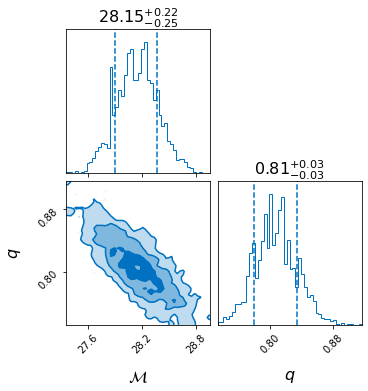

In [23]:
result_short.plot_corner(parameters=["chirp_mass", "mass_ratio"], prior=True)

You can also plot lines indicating specific points. Here, we add the values recorded on [GWOSC](https://www.gw-openscience.org/events/GW150914/). Notably, these fall outside the bulk of the posterior uncertainty here. This is because we limited our prior - if instead we ran the full analysis these agree nicely.

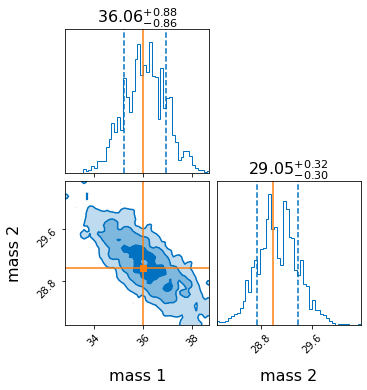

In [19]:
parameters = dict(mass_1=36, mass_2=29)
result_short.plot_corner(parameters)

Earlier we discussed the "correlation" - in this plot we start to see the correlation between $m_1$ and $m_2$.

### Meta data
The result object also stores meta data, like the priors

In [20]:
result_short.priors

{'chirp_mass': Uniform(minimum=27.0, maximum=32.5, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None),
 'mass_ratio': Uniform(minimum=0.5, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None),
 'a_1': DeltaFunction(peak=0.4, name=None, latex_label=None, unit=None),
 'a_2': DeltaFunction(peak=0.3, name=None, latex_label=None, unit=None),
 'tilt_1': DeltaFunction(peak=0.5, name=None, latex_label=None, unit=None),
 'tilt_2': DeltaFunction(peak=1.0, name=None, latex_label=None, unit=None),
 'phi_12': DeltaFunction(peak=1.7, name=None, latex_label=None, unit=None),
 'phi_jl': DeltaFunction(peak=0.3, name=None, latex_label=None, unit=None),
 'psi': DeltaFunction(peak=2.659, name=None, latex_label=None, unit=None),
 'ra': DeltaFunction(peak=1.375, name=None, latex_label=None, unit=None),
 'dec': DeltaFunction(peak=-1.2108, name=None, latex_label=None, unit=None),
 'luminosity_distance': DeltaFunction(peak=4000.0, name=None, latex_label=None, unit=

and details of the analysis itself:

In [21]:
result_short.sampler_kwargs["nlive"]

500

Finally, we can also get out the Bayes factor for the signal vs. Gaussian noise:

In [22]:
print("ln Bayes factor = {} +/- {}".format(
    result_short.log_bayes_factor, result_short.log_evidence_err))

ln Bayes factor = 29.308103027090905 +/- 0.11781995689691561


## Challenge questions

* Rerun the analysis with a different samler. *Hint: [see the docs](https://lscsoft.docs.ligo.org/bilby/samplers.html#switching-between-samplers)*. This may require you to install a new sampler!
* Rerun the analysis with time marginalization. This will require you to change the prior to a uniform prior centered on the simulation value.